In [1]:
import numpy as np
import matplotlib.pyplot as plt
from problem_1.FEMpoisson import FEMPoissonSolver

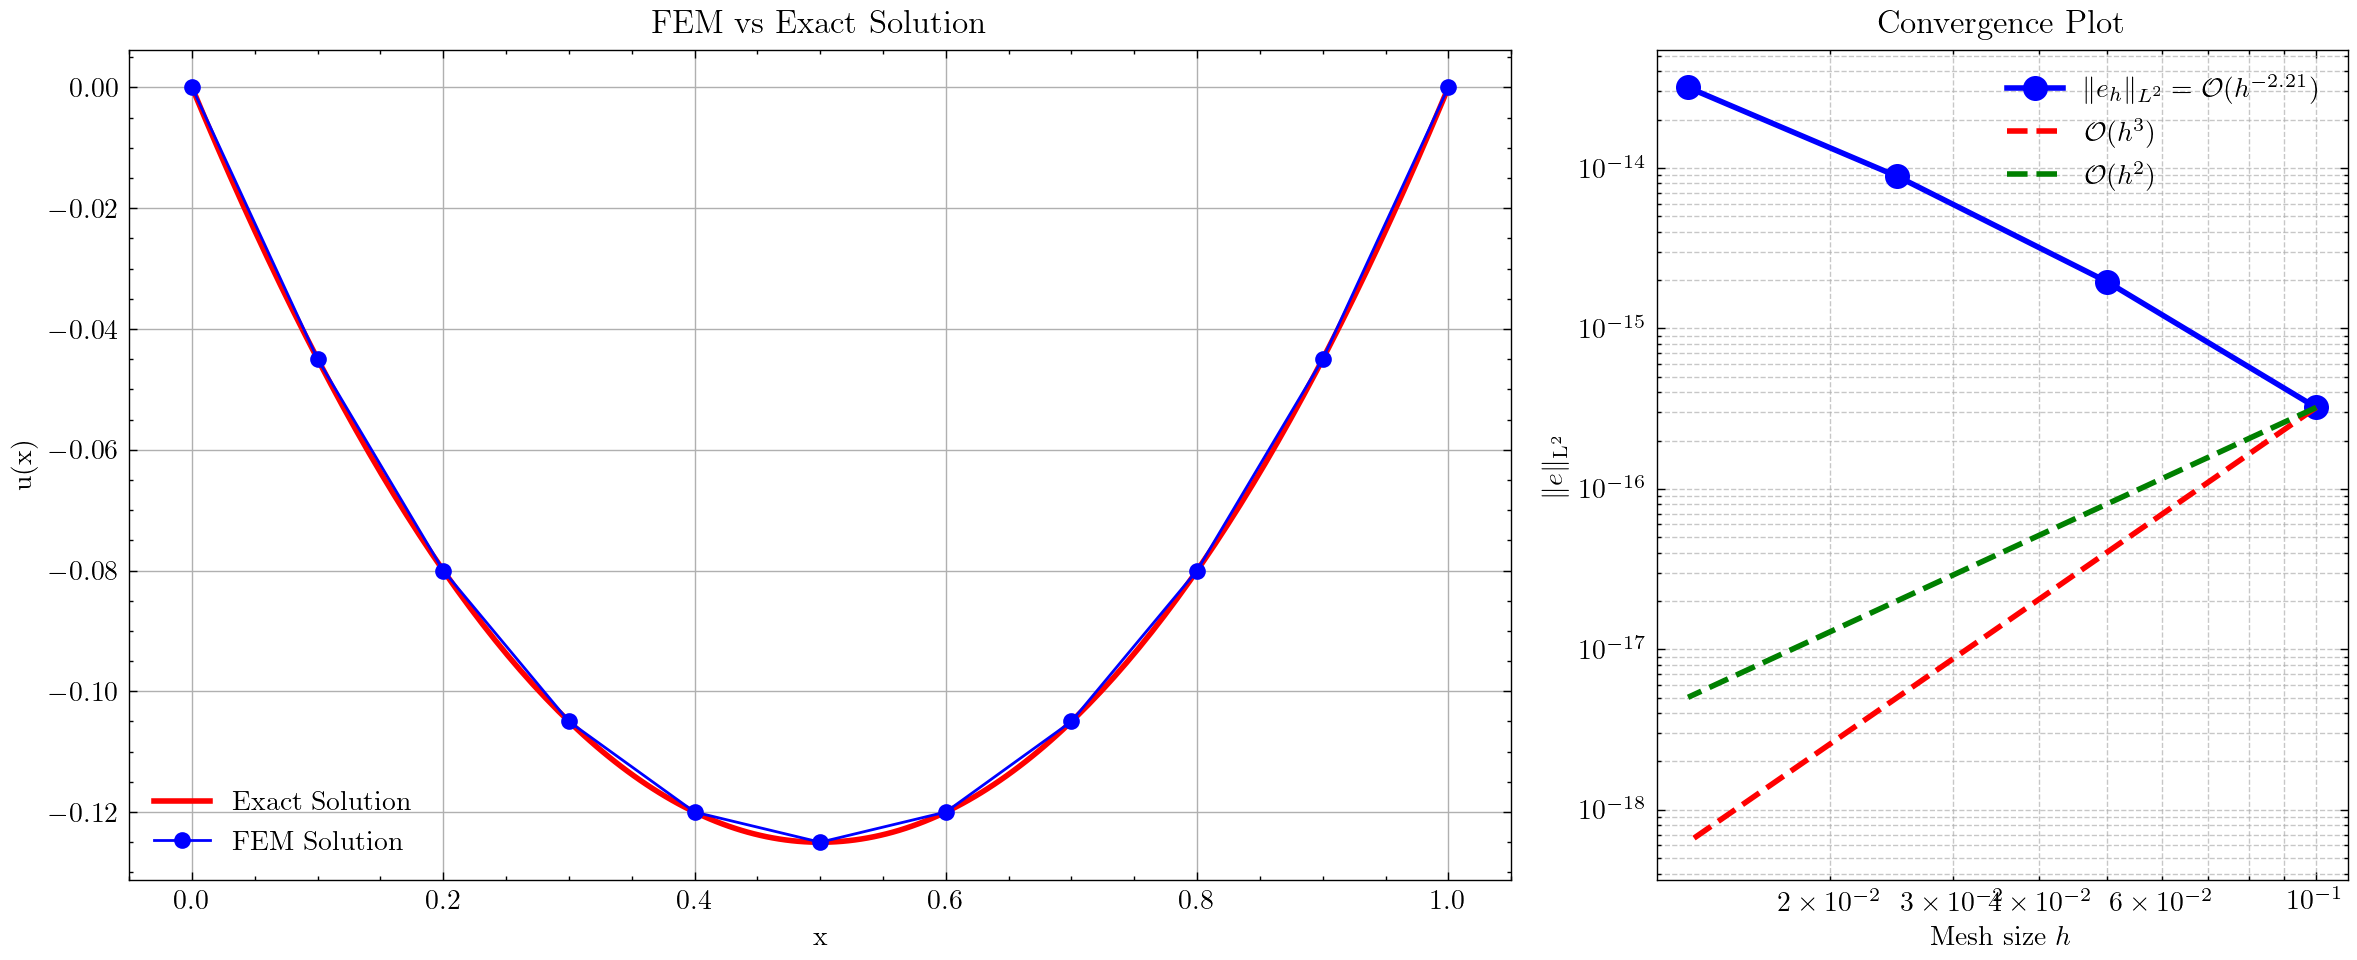

/Users/saether/Library/CloudStorage/OneDrive-NTNU/Skole/Fysikk og matematikk - Master/3. År/6. semester/Numerical Solution of Differential Equations by Difference Methods/exercises/project 2 (tma4212)/problem_1/FEMpoisson.py:129: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1].set_ylim(bottom=0)


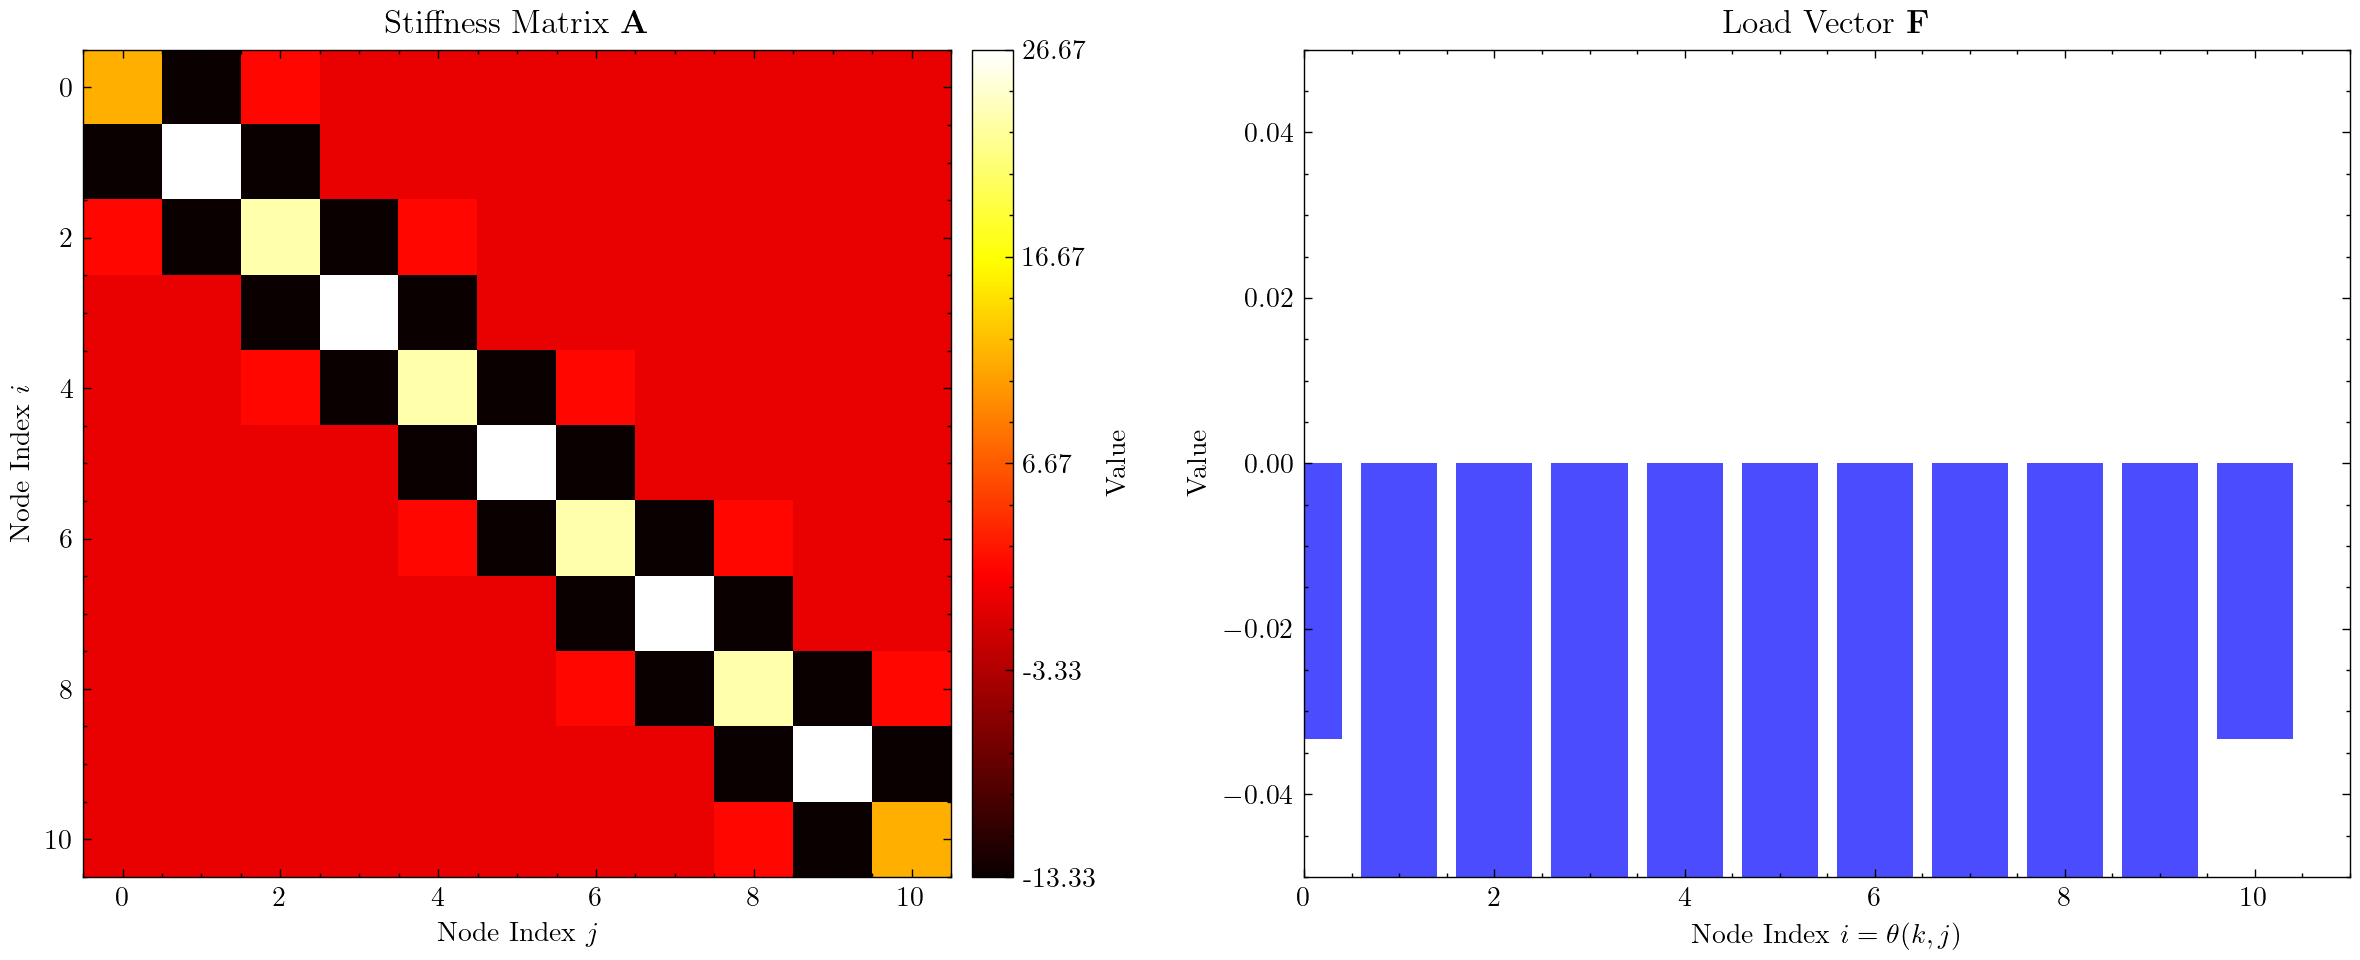

In [2]:

# Example usage:
M = 5
f = lambda x: -1.0
exact = lambda x: (1.0 / 2.0) * (x**2 - x)
solver = FEMPoissonSolver(M, f, exact)
solver.assemble()
solver.solve()
solver.plot(fine_mesh=200, name='1')
solver.plot_stiffness_matrix_and_load_vector(name='1')

L2 Error (Test 5): 0.0024998378238054704


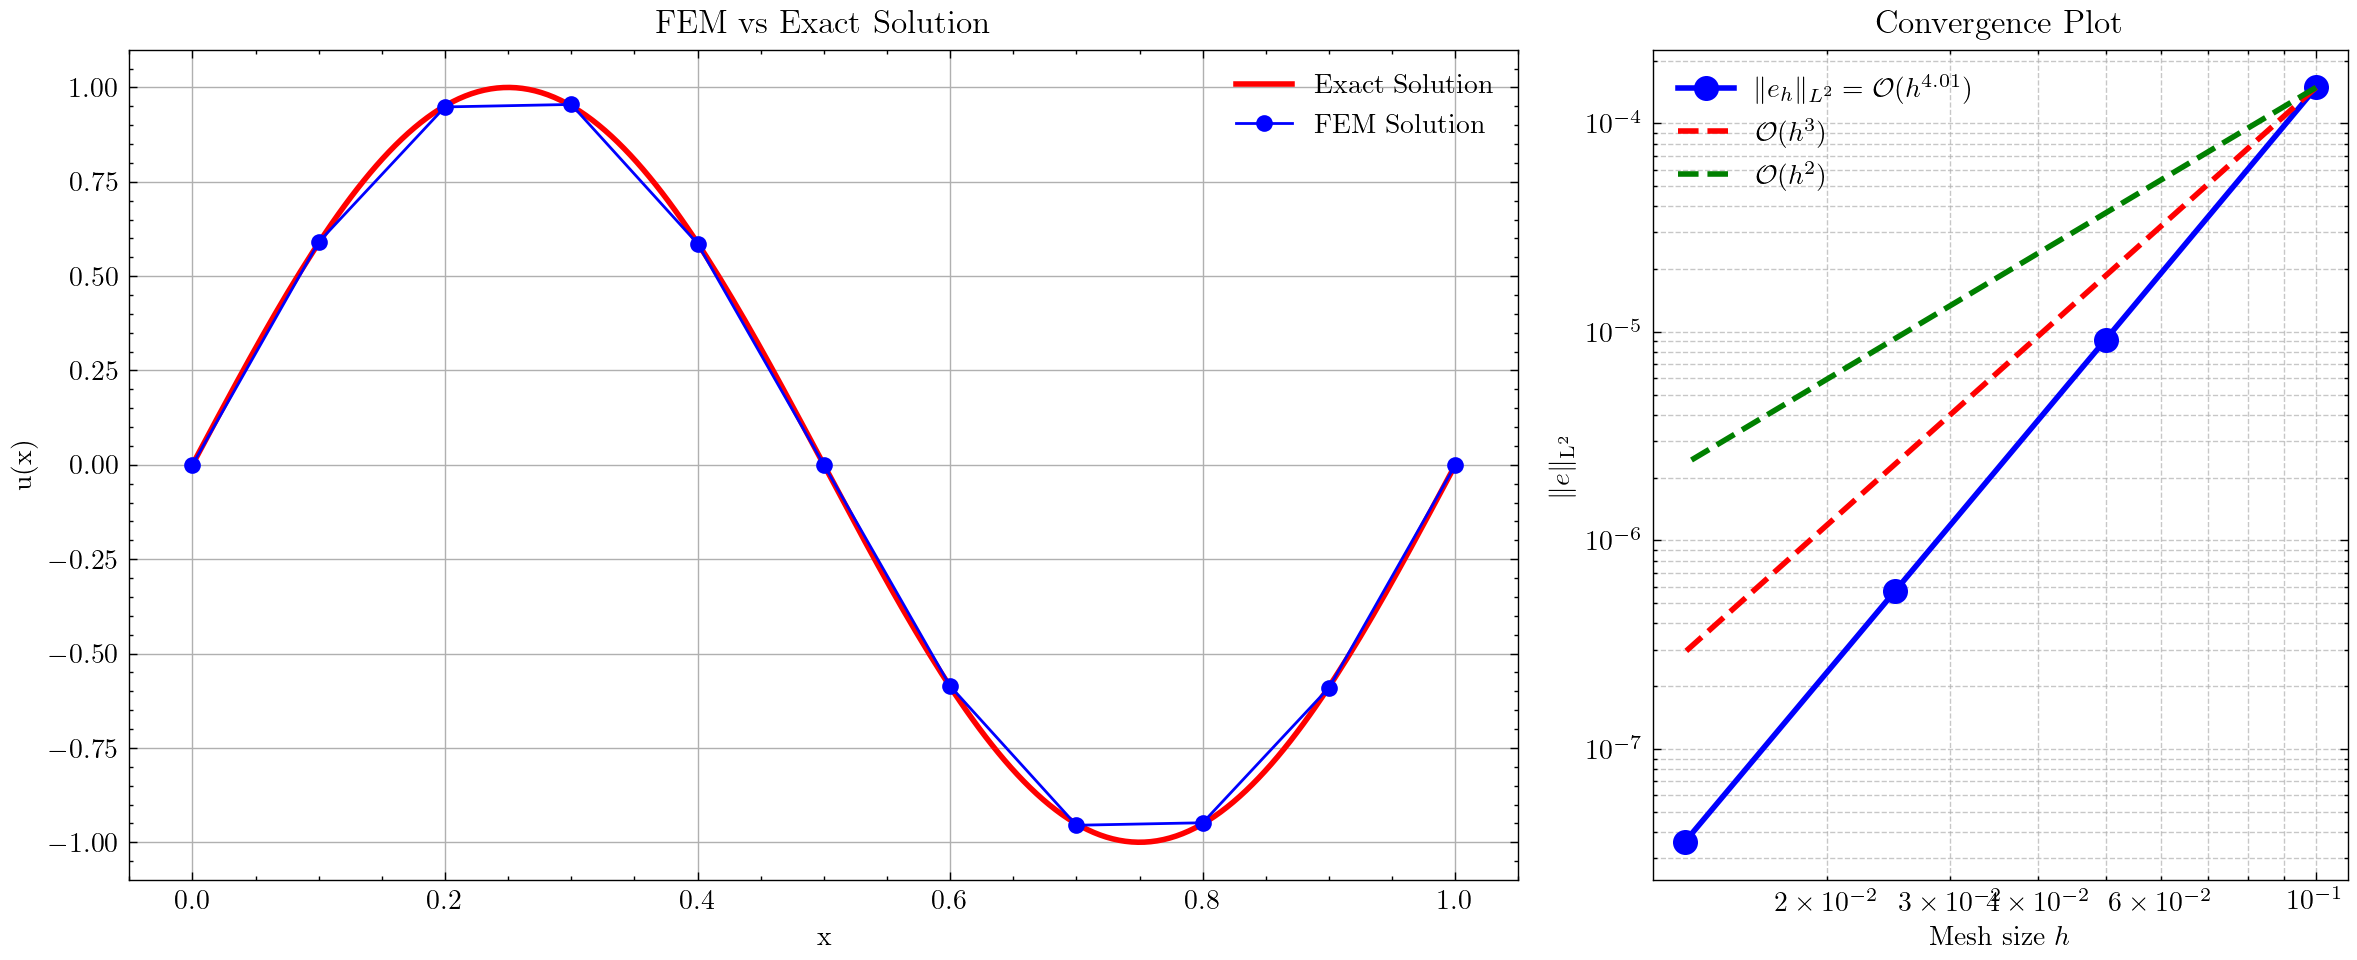

In [3]:

f2 = lambda x: 4*np.pi**2 * np.sin(2*np.pi*x)
exact2 = lambda x: np.sin(2*np.pi*x)
solver2 = FEMPoissonSolver(M=5, f=f2, exact=exact2)
solver2.assemble()
solver2.solve()
print("L2 Error (Test 5):", solver2.L2_error())
solver2.plot(fine_mesh=200, name='2')

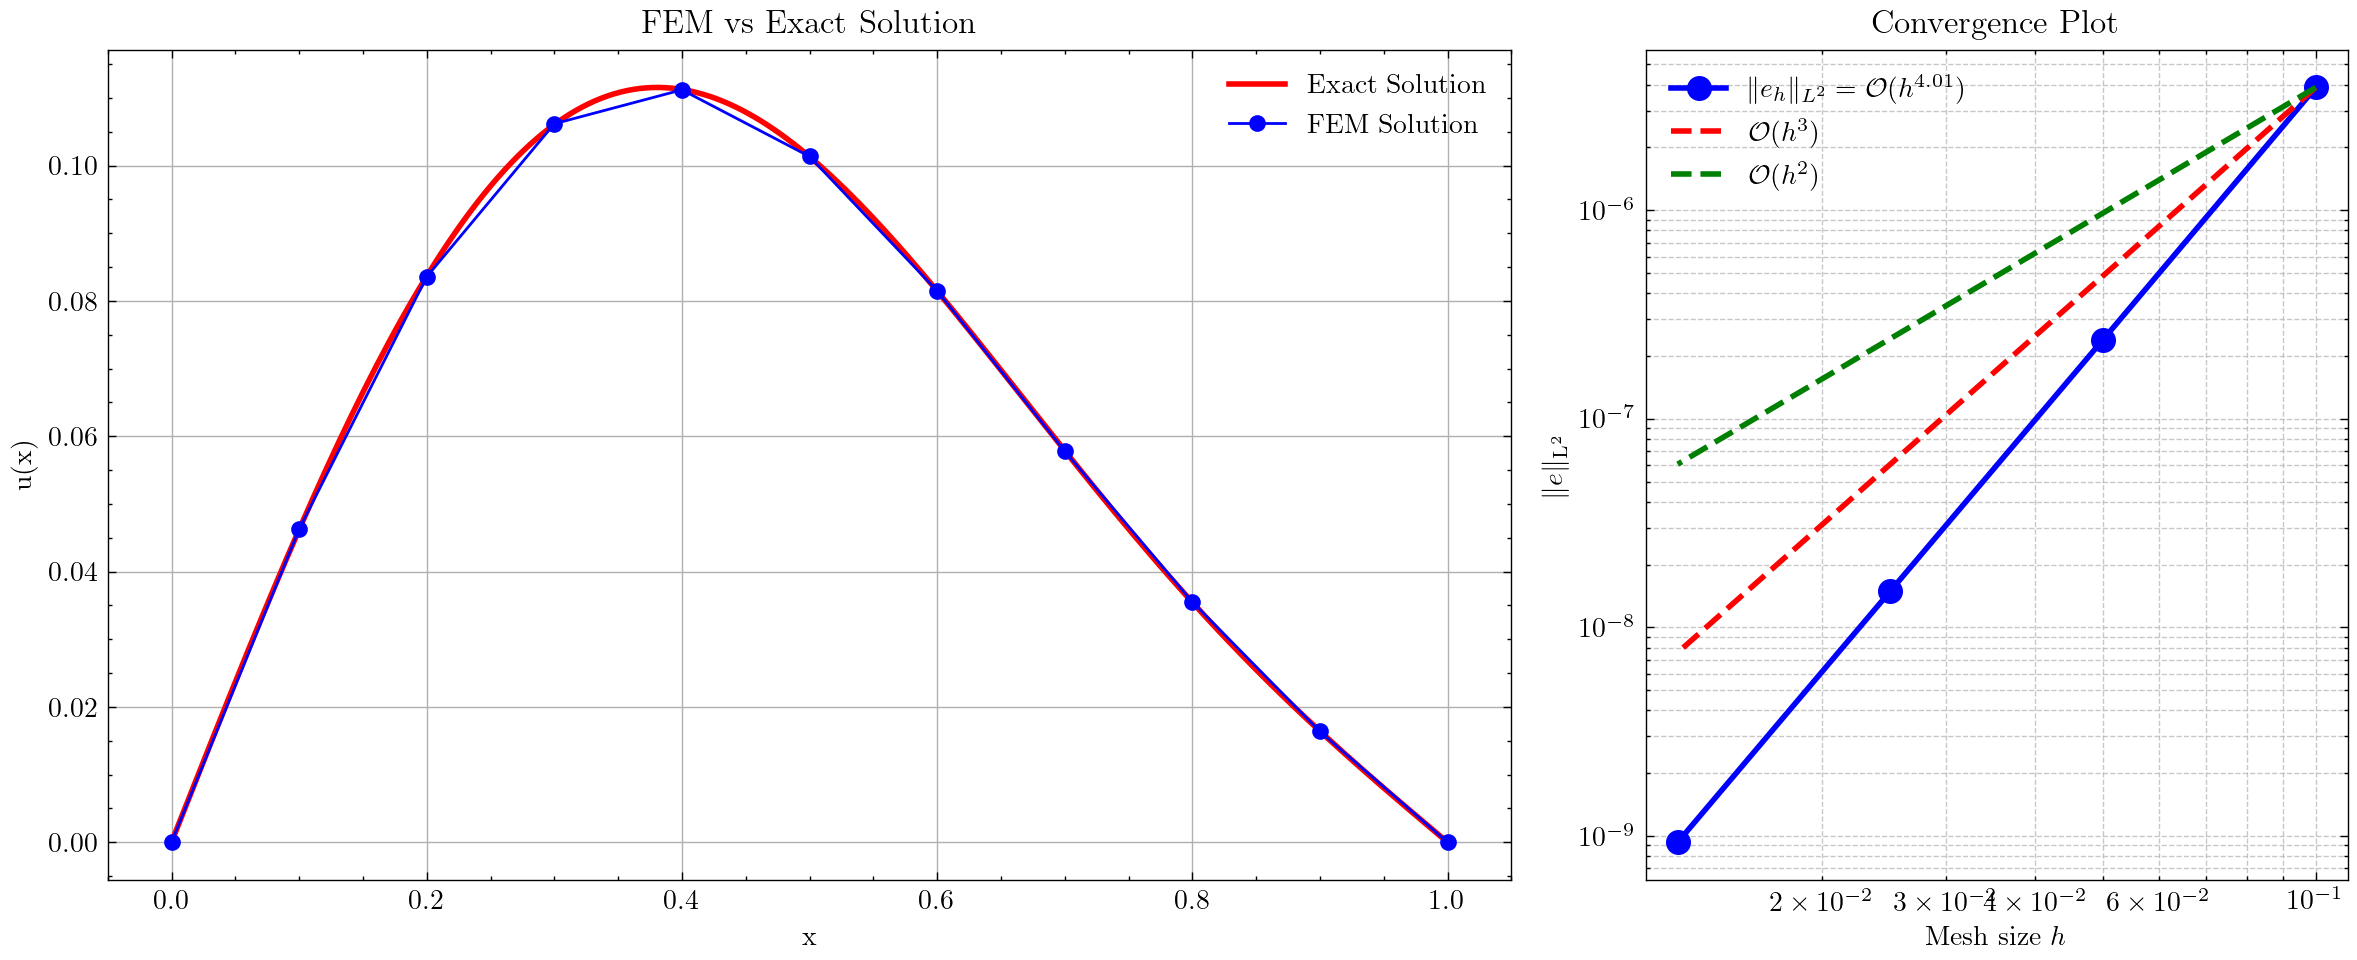

In [4]:

def u_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.sin(np.pi * x) + (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)
def f_test4(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)
solver4 = FEMPoissonSolver(M=5, f=f_test4, exact=u_exact_test4)
solver4.assemble()
solver4.solve()
solver4.plot(fine_mesh=200, name='4')


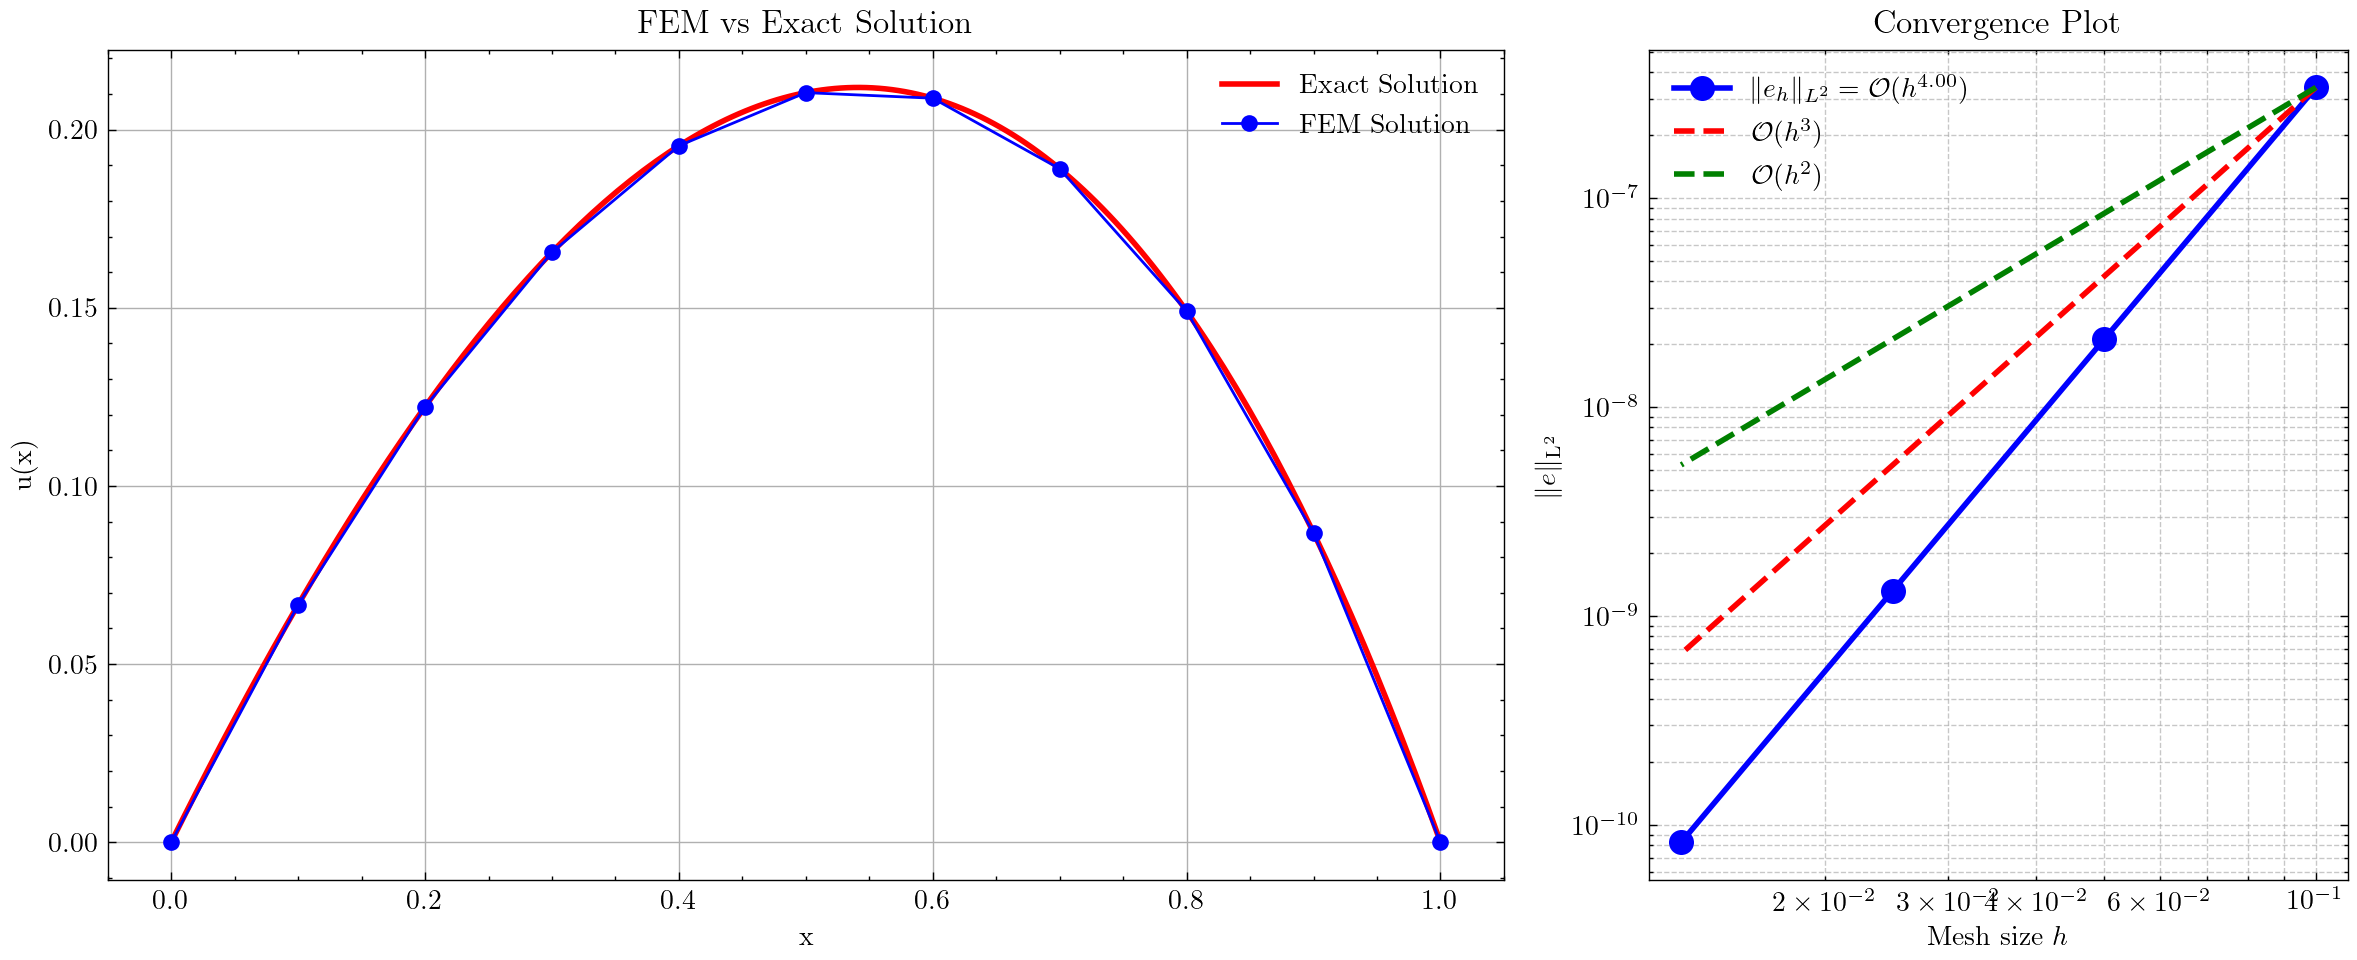

In [5]:


def f_test3(x): return np.exp(x)
def u_exact_test3(x): return -np.exp(x) + (np.e - 1)*x + 1

solver3 = FEMPoissonSolver(M=5, f=f_test3, exact=u_exact_test3)
solver3.assemble()
solver3.solve()
solver3.plot(fine_mesh=200, name='5')
